In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
from tqdm import tqdm
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data = np.load('data\Direction_task_with_dots_synchronised_min.npz')

trainX = data['EEG']
y = torch.tensor(data['labels'][:, 1:3])
ids = data['labels'][:, 0] # ID
print(f"trainX.shape: {trainX.shape}")
print(f"y.shape: {y.shape}")
print(y[0])

# Extracting amplitude and angle
amplitude = y[:, 0]
angle = y[:, 1]

# Convert to x, y positions
x_pos = amplitude * torch.cos(angle)
y_pos = amplitude * torch.sin(angle)

# Stack them into a new tensor
trainY = torch.stack((x_pos, y_pos), dim=1)

# Output the result
trainY.shape

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Aniket Konkar\AppData\Local\Temp\ipykernel_13824\2953534079.py:1: SyntaxWarning: invalid escape sequence '\D'
  data = np.load('data\Direction_task_with_dots_synchronised_min.npz')


trainX.shape: (17830, 500, 129)
y.shape: torch.Size([17830, 2])
tensor([309.3279,   0.7193], dtype=torch.float64)


torch.Size([17830, 2])

# Visualize

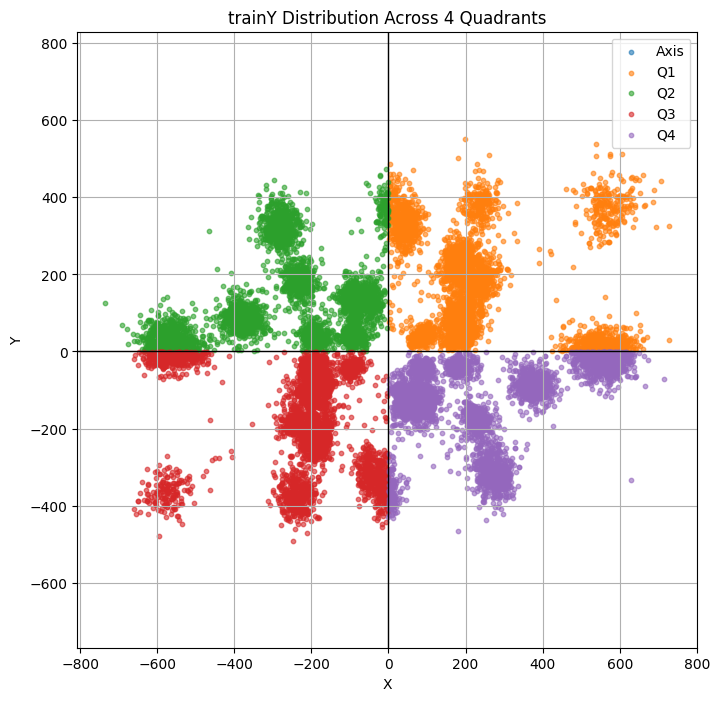

In [9]:
import matplotlib.pyplot as plt

# Determine quadrants
quadrants = []
for x, y in trainY:
    if x > 0 and y > 0:
        quadrants.append(1)
    elif x < 0 and y > 0:
        quadrants.append(2)
    elif x < 0 and y < 0:
        quadrants.append(3)
    elif x > 0 and y < 0:
        quadrants.append(4)
    else:
        quadrants.append(0)  # On axis
quadrants = np.array(quadrants)

# Plot
colors = ['gray', 'red', 'blue', 'green', 'purple']
labels = ['Axis', 'Q1', 'Q2', 'Q3', 'Q4']

plt.figure(figsize=(8, 8))
for q in range(5):
    idx = quadrants == q
    plt.scatter(trainY[idx, 0], trainY[idx, 1], label=labels[q], alpha=0.6, s=10)

plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.title("trainY Distribution Across 4 Quadrants")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [3]:
import math
import numpy as np

def split(ids, train, val, test):
    # proportions of train, val, test
    assert (train+val+test == 1)
    IDs = np.unique(ids)
    num_ids = len(IDs)

    # priority given to the test/val sets
    test_split = math.ceil(test * num_ids)
    val_split = math.ceil(val * num_ids)
    train_split = num_ids - val_split - test_split

    train = np.where(np.isin(ids, IDs[:train_split]))[0]
    val = np.where(np.isin(ids, IDs[train_split:train_split+val_split]))[0]
    test = np.where(np.isin(ids, IDs[train_split+val_split:]))[0]
    
    return train, val, test

train, val, test = split(ids, 0.7, 0.15, 0.15)
X_train, y_train = trainX[train], trainY[train]
X_val, y_val = trainX[val], trainY[val]
X_test, y_test = trainX[test], trainY[test]

print(f"X_train.shape:{X_train.shape} y_train.shape: {y_train.shape}")
print(f"X_val.shape:{X_val.shape} y_val.shape: {y_val.shape}")
print(f"X_test.shape:{X_test.shape} y_test.shape: {y_test.shape}")

X_train.shape:(12613, 500, 129) y_train.shape: torch.Size([12613, 2])
X_val.shape:(2671, 500, 129) y_val.shape: torch.Size([2671, 2])
X_test.shape:(2546, 500, 129) y_test.shape: torch.Size([2546, 2])


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (N, 2)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

C:\Users\Aniket Konkar\AppData\Local\Temp\ipykernel_13824\739164614.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (N, 2)
C:\Users\Aniket Konkar\AppData\Local\Temp\ipykernel_13824\739164614.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
C:\Users\Aniket Konkar\AppData\Local\Temp\ipykernel_13824\739164614.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.t

### Model

In [5]:
import torch
import transformers
from transformers import ViTModel
import torch
from torch import nn
import transformers

class EEGViT_pretrained(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=256,
            kernel_size=(1, 36),
            stride=(1, 36),
            padding=(0,2),
            bias=False
        )
        self.batchnorm1 = nn.BatchNorm2d(256, False)
        model_name = "google/vit-base-patch16-224"
        config = transformers.ViTConfig.from_pretrained(model_name)
        config.update({'num_channels': 256})
        config.update({'image_size': (129,14)})
        config.update({'patch_size': (8,1)})

        model = transformers.ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)
        model.vit.embeddings.patch_embeddings.projection = torch.nn.Conv2d(256, 768, kernel_size=(8, 1), stride=(8, 1), padding=(0,0), groups=256)
        model.classifier=torch.nn.Sequential(torch.nn.Linear(768,1000,bias=True),
                                     torch.nn.Dropout(p=0.1),
                                     torch.nn.Linear(1000,2,bias=True))
        self.ViT = model
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.ViT.forward(x).logits
        
        return x

c:\Users\Aniket Konkar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config


In [6]:
batch_size = 64
n_epoch = 15
learning_rate = 1e-4
model = EEGViT_pretrained()
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- vit.embeddings.patch_embeddings.projection.weight: found shape torch.Size([768, 3, 16, 16]) in the checkpoint and torch.Size([768, 256, 8, 1]) in the model instantiated
- vit.embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 225, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import copy
from tqdm import tqdm

torch.cuda.empty_cache()
model = model.to(device)
criterion = criterion.to(device)

# Initialize lists to store losses
train_losses = []
val_losses = []
test_losses = []
best_val_loss = float('inf')
best_model_wts = None

print('Training...')

# Train the model
for epoch in range(n_epoch):
    model.train()
    epoch_train_loss = 0.0

    for i, (inputs, targets) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch}/{n_epoch}"):
        inputs = inputs.to(device).unsqueeze(1).permute(0, 1, 3, 2)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        # Optional: print loss every 5 batches
        if i % 100 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch}, Train Loss: {epoch_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device).unsqueeze(1).permute(0, 1, 3, 2)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}")

        # Save best model based on val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    # Test
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device).unsqueeze(1).permute(0, 1, 3, 2)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            test_loss += loss.item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        rmse = test_loss ** 0.5
        print(f"Epoch {epoch}, Test Loss (MSE): {test_loss:.4f}, RMSE: {rmse:.4f}")

    if scheduler is not None:
        scheduler.step()

# Load best model weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Best model loaded with val loss:", best_val_loss)

# Save best model
torch.save(model.state_dict(), "encoder_weights_direction_task.pt")
print("Best model saved as 'best_model.pt'.")

# Save encoder weights
if hasattr(model, 'encoder'):
    torch.save(model.encoder.state_dict(), "encoder_weights_direction_task.pt")
    print("Encoder weights saved as 'encoder_weights_direction_task.pt'.")
else:
    print("Model does not have an 'encoder' attribute to save.")

Training...


Epoch 0/15: 1it [01:08, 68.01s/it]

Epoch 0, Batch 0, Loss: 60220.0078125


Epoch 0/15: 101it [24:29, 16.36s/it]

Epoch 0, Batch 100, Loss: 40842.703125


Epoch 0/15: 198it [49:27, 14.99s/it]


Epoch 0, Train Loss: 42187.6852
Epoch 0, Val Loss: 32287.2390
Epoch 0, Test Loss (MSE): 27300.2927, RMSE: 165.2280


Epoch 1/15: 1it [00:16, 16.66s/it]

Epoch 1, Batch 0, Loss: 36769.703125


Epoch 1/15: 101it [23:05, 13.33s/it]

Epoch 1, Batch 100, Loss: 24353.19140625


Epoch 1/15: 198it [46:18, 14.03s/it]


Epoch 1, Train Loss: 24748.6946
Epoch 1, Val Loss: 20952.4036
Epoch 1, Test Loss (MSE): 18046.4966, RMSE: 134.3372


Epoch 2/15: 1it [00:16, 16.25s/it]

Epoch 2, Batch 0, Loss: 23218.923828125


Epoch 2/15: 101it [24:05, 17.12s/it]

Epoch 2, Batch 100, Loss: 9658.0234375


Epoch 2/15: 198it [50:16, 15.24s/it]


Epoch 2, Train Loss: 12517.0398
Epoch 2, Val Loss: 11481.4872
Epoch 2, Test Loss (MSE): 8049.8457, RMSE: 89.7209


Epoch 3/15: 1it [00:17, 17.45s/it]

Epoch 3, Batch 0, Loss: 10662.0830078125


Epoch 3/15: 101it [23:57, 14.08s/it]

Epoch 3, Batch 100, Loss: 15659.2314453125


Epoch 3/15: 198it [47:11, 14.30s/it]


Epoch 3, Train Loss: 7843.5434
Epoch 3, Val Loss: 11006.8238
Epoch 3, Test Loss (MSE): 7135.5731, RMSE: 84.4723


Epoch 4/15: 1it [00:12, 12.79s/it]

Epoch 4, Batch 0, Loss: 10661.109375


Epoch 4/15: 101it [21:18, 12.64s/it]

Epoch 4, Batch 100, Loss: 6775.720703125


Epoch 4/15: 198it [41:41, 12.63s/it]


Epoch 4, Train Loss: 6724.4200
Epoch 4, Val Loss: 9921.3491
Epoch 4, Test Loss (MSE): 7560.8576, RMSE: 86.9532


Epoch 5/15: 1it [00:13, 13.65s/it]

Epoch 5, Batch 0, Loss: 8801.501953125


Epoch 5/15: 101it [22:30, 14.95s/it]

Epoch 5, Batch 100, Loss: 11779.17578125


Epoch 5/15: 198it [43:49, 13.28s/it]


Epoch 5, Train Loss: 6101.6091
Epoch 5, Val Loss: 9590.0223
Epoch 5, Test Loss (MSE): 6363.6493, RMSE: 79.7725


Epoch 6/15: 1it [00:13, 13.80s/it]

Epoch 6, Batch 0, Loss: 3712.24609375


Epoch 6/15: 101it [23:16, 13.85s/it]

Epoch 6, Batch 100, Loss: 3984.2666015625


Epoch 6/15: 198it [46:05, 13.97s/it]


Epoch 6, Train Loss: 5072.0670
Epoch 6, Val Loss: 9066.0843
Epoch 6, Test Loss (MSE): 5350.2799, RMSE: 73.1456


Epoch 7/15: 1it [00:15, 15.67s/it]

Epoch 7, Batch 0, Loss: 7766.662109375


Epoch 7/15: 101it [22:58, 13.02s/it]

Epoch 7, Batch 100, Loss: 4975.86328125


Epoch 7/15: 198it [43:38, 13.22s/it]


Epoch 7, Train Loss: 4724.4729
Epoch 7, Val Loss: 8967.5968
Epoch 7, Test Loss (MSE): 5324.7440, RMSE: 72.9708


Epoch 8/15: 1it [00:12, 12.76s/it]

Epoch 8, Batch 0, Loss: 2769.9814453125


Epoch 8/15: 101it [21:54, 13.01s/it]

Epoch 8, Batch 100, Loss: 4021.349365234375


Epoch 8/15: 198it [42:43, 12.95s/it]


Epoch 8, Train Loss: 4586.7983
Epoch 8, Val Loss: 8843.3765
Epoch 8, Test Loss (MSE): 5324.1546, RMSE: 72.9668


Epoch 9/15: 1it [00:11, 12.00s/it]

Epoch 9, Batch 0, Loss: 7968.2041015625


Epoch 9/15: 101it [20:20, 12.08s/it]

Epoch 9, Batch 100, Loss: 3321.296630859375


Epoch 9/15: 198it [39:32, 11.98s/it]


Epoch 9, Train Loss: 4544.0395
Epoch 9, Val Loss: 8915.2752
Epoch 9, Test Loss (MSE): 5784.0170, RMSE: 76.0527


Epoch 10/15: 1it [00:12, 12.07s/it]

Epoch 10, Batch 0, Loss: 4230.109375


Epoch 10/15: 101it [20:04, 11.92s/it]

Epoch 10, Batch 100, Loss: 4124.38818359375


Epoch 10/15: 198it [39:18, 11.91s/it]


Epoch 10, Train Loss: 4383.6910
Epoch 10, Val Loss: 8825.5983
Epoch 10, Test Loss (MSE): 5454.0455, RMSE: 73.8515


Epoch 11/15: 1it [00:13, 13.85s/it]

Epoch 11, Batch 0, Loss: 2290.714599609375


Epoch 11/15: 101it [23:16, 13.84s/it]

Epoch 11, Batch 100, Loss: 7920.56201171875


Epoch 11/15: 198it [45:24, 13.76s/it]


Epoch 11, Train Loss: 4323.8951
Epoch 11, Val Loss: 8706.7068
Epoch 11, Test Loss (MSE): 5368.2846, RMSE: 73.2686


Epoch 12/15: 1it [00:13, 13.74s/it]

Epoch 12, Batch 0, Loss: 7414.197265625


Epoch 12/15: 101it [23:00, 13.66s/it]

Epoch 12, Batch 100, Loss: 4823.5595703125


Epoch 12/15: 198it [44:58, 13.63s/it]


Epoch 12, Train Loss: 4108.3430
Epoch 12, Val Loss: 8846.7400
Epoch 12, Test Loss (MSE): 5291.2326, RMSE: 72.7409


Epoch 13/15: 1it [00:13, 13.61s/it]

Epoch 13, Batch 0, Loss: 2352.32421875


Epoch 13/15: 101it [23:11, 13.78s/it]

Epoch 13, Batch 100, Loss: 5171.771484375


Epoch 13/15: 198it [47:29, 14.39s/it]


Epoch 13, Train Loss: 4081.4503
Epoch 13, Val Loss: 8928.8601
Epoch 13, Test Loss (MSE): 5290.2010, RMSE: 72.7338


Epoch 14/15: 1it [00:13, 13.78s/it]

Epoch 14, Batch 0, Loss: 5317.9072265625


Epoch 14/15: 101it [23:55, 13.54s/it]

Epoch 14, Batch 100, Loss: 11106.771484375


Epoch 14/15: 198it [45:53, 13.91s/it]


Epoch 14, Train Loss: 4058.9008
Epoch 14, Val Loss: 8843.5854
Epoch 14, Test Loss (MSE): 5465.1090, RMSE: 73.9264
Best model loaded with val loss: 8706.706795828683
Best model saved as 'best_model.pt'.
Model does not have an 'encoder' attribute to save.
